**HWRS 582 GHW1: Box Model**

*MODFLOW files used:*
   <br>DIS - Discretization input
   <br>BAS - Basic
   <br>LPF - Layer-Property Flow
   <br>OC  - Output Control
   <br>PCG - Preconditioned Conjugate Gradient
   <br>WEL - Well
    
*Model description:*
<br>Build a steady state box model.  The model should have 25x25 cells, each 100 m in x and in y.  There is one layer, 10 m thick.  The medium is homogeneous with K = 1.0 m/day in x and y and 0.1 m/day in z.  The porosity is 0.35, specific yield is 0.3, and storage coefficient is 0.001.  The right boundary is constant flow with a total of 25 m3/day entering the domain.  The left boundary is a constant head of 7 m relative to the datum, which is located at the bottom of the domain. Add particles at the mid-depth of the layer along the right boundary.

**Import Python packages**

In [1]:
#Import FloPy:
##Simple version:
import flopy

##General version for any system (in case not properly installed) (uncomment this section to use):
#import os
#import sys
#import numpy as np
#flopypth = os.path.join('..', '..', 'flopy')
#if flopypth not in sys.path:
#    sys.path.append(flopypth)

#Import analysis & plotting tools:
import numpy as np
import flopy.utils.binaryfile as bf
import os
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


ModuleNotFoundError: No module named 'flopy.utils'

**Model setup**

In [3]:
#Create model object:
modelname = "GHW1"
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
#this line calls the flopy function 'Modflow', and tells flopy what the model name should be and what version of MODFLOW to use
#in general, functions have the form:
# outputs = function_name(input1, input2, input3)
# a description of the inputs can be viewed by putting the cursor right after the opening
#parenthesis and pressing Shift+Tab


#Define model parameters:
#the names of these variables are arbitrary, but the formats (integer vs. decimal) need to match what the flopy 
#documentation asks for.
##Model grid:
nrow = 25          #number of rows (integer)
ncol = 25          #number of columns (integer)
nlay = 1           #number of layers (integer)
delr = 100.0       #width of each cell along rows (so really this is column width along x axis) (float, i.e. decimal)
delc = 100.0       #width of each cell along columns (so really this is row height along y axis) (float)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height
ztop = 10.0        #top elevation (float)
zbot = 0.0         #bottom elevation (float)
#delr = Lx/ncol    #cell width along the rows - if defining total model width uncomment this and comment out lines 47 & 48
#delc = Ly/nrow    #cell width along the columns
delv = (ztop - zbot) / nlay     #cell height in z axis
botm = np.linspace(ztop, zbot, nlay + 1) #bottom elevation of each layer - linspace generates an array of nlay+1 linearly spaced values between ztop and zbot

##Medium properties:
K_horiz = 1.0   #assign horizontal hydraulic conductivity (along rows)
K_ratio = 1.0   #assign ratio of Ky/Kx (aka Kcol/Krow)
K_vert = 0.1    #assign vertical hydraulic conductivity (along z axis)
n = 0.35        #assign porosity
Ss = 0.001      #assign storage coefficient
Sy = 0.3        #assign specific yield

#Print model summary:
print("Model name: ", modelname)           #print the strings (i.e. text) for the model name
text = '''Model grid: {} layer x {} rows x {} cols;  Cell dimensions: {}m x {}m x {}m
Parameters: Kx = {}m/d, Ky = {}m/d, Kz = {}m/d
n = {}, Sy = {}, S = {}'''                  #define a string for the model info, with blanks in each bracket
print(text.format(nlay,nrow,ncol, delv,delr,delc, K_horiz,K_horiz,K_vert, n,Sy,Ss))  #print the above string, and fill the
                                                                                     #brackets with these variable values

Model name:  GHW1
Model grid: 1 layer x 25 rows x 25 cols;  Cell dimensions: 10.0m x 100.0m x 100.0m
Parameters: Kx = 1.0m/d, Ky = 1.0m/d, Kz = 0.1m/d
n = 0.35, Sy = 0.3, S = 0.001


**Create package objects & write MODFLOW input files**

In [4]:
#Note: running this section multiple times without changing filenames will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#DIS (Discretization): Creates model grid
#full list of parameters: https://modflowpy.github.io/flopydoc/mfdis.html
#if left unspecified, defaults to units of meters and unspecified time
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:])     
       

#BAS (Basic): Assigns constant head boundaries.
#if ibound < 0, constant head, if = 0, inactive, if > 0 active.
#create arrays to indicate active cells (ibound) and starting heads (H_init):
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)    #integer array of dim (z,y,x), makes all cells active                                                     
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0

#set head at left boundary:
H_left = 7.                 #define constant head value of 7m
ibound[:,:,0] = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
H_init[:, :, :] = H_left    #assign desired starting head value to all cells
#note: brackets select a certain range of locations within an array

bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=H_init)    #create BAS object


#LPF (Layer Property Flow): Assigns horizontal & vertical flow parameters between cells
#Only one of either the BCF, LPF, or HUF2 packages should be used to control flow between cells
#Can also in this package set confined/unconfined (defaults to confined), cell-by-cell Ks as an array, 
#storage, specific yield, etc.
#defaults to confined, so need to set to unconfined
uncnf = 1      #0=confined, >0 = unconfined
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, ss=Ss,
            sy=Sy,storagecoefficient=True, ipakcb=53) #assigns horiz  and vertical Ks and saves cell-by-cell budget data


#OC (Output Control): Decides what outputs to save
#This rarely needs to be changed
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)   #create output control file using dictionary
#(0,0) tells OC package to save data for stress period 1, time step 1.
#note: curly braces are used to create a dictionary, where each entry has an associated 'definition'


#PCG (Preconditioned Conjugate Gradient):
#This rarely needs to be changed
pcg = flopy.modflow.ModflowPcg(mf) #uses default settings


#WEL (Well): Adds wells (i.e. constant flow boundaries)
#Requires an array with a flux value for each cell that will have a well in it
Q_in = 25.                           #total flow crossing right boundary (m3/day)
Q_cell = Q_in / nrow                 #flow entering each cell (m3/day)
fluxes = np.zeros((nrow,4))          #create array of zeros (# of rows, # of parameters: [lay, row, col, flux])
for i in range(nrow):                #iterate over rows & assign constant flux to each cell in leftmost column
    fluxes[i,:] = [0,i,ncol-1,Q_cell]     #[lay, row, col, flux]
    
sp_fluxes = {0: fluxes}              #create a dictionary with entries for each stress period
wel = flopy.modflow.mfwel.ModflowWel(mf, stress_period_data=sp_fluxes)  #create object for WEL package


#Write MODFLOW input files:
mf.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in


**Run MODFLOW**

In [5]:
#The executable MODFLOW file must be in same working directory as this file, 
#and have the name specified when the model object was created
#if model runs successfully, success = 1

success, buff = mf.run_model()


FloPy is using the following executable to run the model: mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: GHW1.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/03/04 12:27:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2018/03/04 12:27:28
 Elapsed run time:  0.040 Seconds

  Normal termination of simulation


**Post-process results**

In [6]:
#Get outputs:
#This section usually doesn't change much
hds = bf.HeadFile(modelname+'.hds')    #reads the binary head file (concatenates the model name with the string '.hds' to find it)
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells
         #string options are in the list file under output control (make sure to include spaces!)

C:\Users\Chloe\Anaconda3\envs\HWR582\lib\site-packages\flopy\utils\binaryfile.py:756: FutureWarning: Assignment between structured arrays with different field names will change in numpy 1.14.

Previously fields in the dst would be set to the value of the identically-named field in the src. In numpy 1.14 fields will instead be assigned 'by position': The Nth field of the dst will be set to the Nth field of the src array.

See the release notes for details
  header2 = header2.astype(self.header2_dtype)


In [7]:
#Print outputs to reality-check 
#(optional: this section will only run if 'run' is set to True, to turn off, set 'run' to False)

run = True          
if run == True:
    
    print('timesteps:', times)         
    print('final head:', 'dimensions', np.shape(head), '\n', head)    
    print('initial head:', 'dimensions', np.shape(H_init), '\n', H_init)
    print('well fluxes:', 'dimensions', np.shape(fluxes), '\n', fluxes)
    
    #note: np.shape gives the dimensions of an array, '\n' goes to a new line


timesteps: [1.0]
final head: dimensions (1, 25, 25) 
 [[[ 7.          7.1414423   7.28013659  7.41623592  7.54988194  7.68120241
    7.81031418  7.93732548  8.06233597  8.1854372   8.3067131   8.42624378
    8.54410267  8.66035652  8.77507114  8.88830471  9.00011349  9.11054897
    9.21966267  9.32749939  9.43410397  9.53951645  9.64377689  9.74692154
    9.84898663]
  [ 7.          7.1414423   7.28013611  7.41623592  7.54988194  7.68120193
    7.81031418  7.93732548  8.06233597  8.18543625  8.3067131   8.42624378
    8.54410267  8.66035652  8.77507019  8.88830376  9.00011253  9.11054897
    9.21966267  9.32749939  9.43410397  9.53951645  9.64377689  9.74692249
    9.84898663]
  [ 7.          7.1414423   7.28013611  7.41623592  7.54988194  7.68120193
    7.8103137   7.93732548  8.06233597  8.18543625  8.3067131   8.42624378
    8.54410172  8.66035652  8.77507019  8.88830376  9.00011253  9.11054897
    9.21966267  9.32749939  9.43410301  9.53951645  9.64377689  9.74692249
    9.84898663

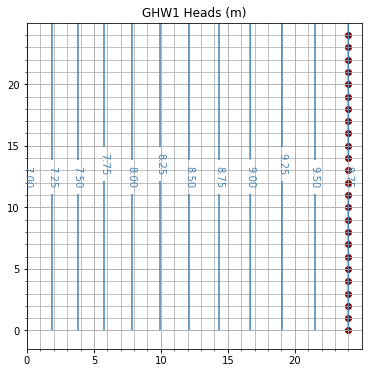

In [20]:
#Plot contour map of heads in Layer 1:

#Create figure & plot data:
f1,ax1 = plt.subplots(1,1,figsize=(6,6)) #create & return empty figure & axes at position (row, col) of size 6x6 inches
levels = np.arange(1,10,0.25)  #creates an array of values from 1 to 9 with a step size of 0.25, used to determine which contour values to draw
extent = (0, ncol, 0, nrow)              #sets plot boundaries (x0,x1,y0,y1)
c = plt.contour(head[0,:,:], extent=extent, levels=levels, colors='SteelBlue')  #plots contours for all rows & columns in layer 1
s = plt.scatter(fluxes[:,2], fluxes[:,1], c='DarkRed')    #plots well locations (col = x, row = y) in red

#Format grid & axes:
major_ticks = np.arange(0,nrow,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,nrow)           #creates an array for minor tick marks every 1

ax1.set_xticks(major_ticks)             #sets major ticks
ax1.set_xticks(minor_ticks, minor=True) #sets minor ticks
ax1.set_yticks(major_ticks)
ax1.set_yticks(minor_ticks, minor=True)

ax1.grid(which='both')                  #turns grid on for both major and minor ticks

#Labels:
plt.clabel(c, fmt='%1.2f')              #adds contour labels as floats with 2 decimal places       
plt.title('GHW1 Heads (m)')             #adds a title

#Show figure:
plt.show()                              #actually displays figures below (not all computers need this)

#Save figure:
plt.savefig('GHW1_head_contours.png')   #save figure as a .png file

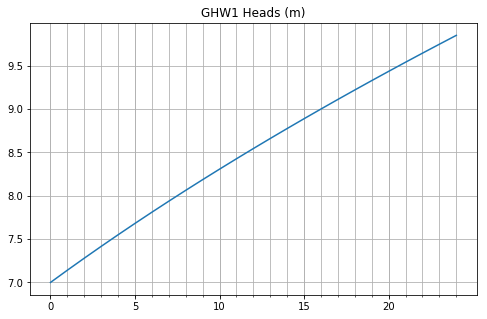

In [23]:
#Plot cross-section of heads along center row:

#Create figure & plot data:
f2,ax2 = plt.subplots(1,1,figsize=(8,5)) #create & return empty figure & axes at position (row, col) of size 8x5 inches
l = plt.plot(np.arange(ncol), head[0,12,:]) #plots heads at layer 0, row 12, all columns

#Format grid & axes:
major_ticks = np.arange(0,25,5)         #creates an array for major tick marks every 5
minor_ticks = np.arange(0,25)           #creates an array for minor tick marks every 1

ax2.set_xticks(major_ticks)             #sets major ticks
ax2.set_xticks(minor_ticks, minor=True) #sets minor ticks

ax2.grid(which='both')                  #turns grid on for both major and minor ticks   
plt.title('GHW1 Heads (m)')             #adds a title

#Show & save figure:
plt.show()                              #display figure
plt.savefig('GHW1_head_xsec.png')       #save figure as a .png file

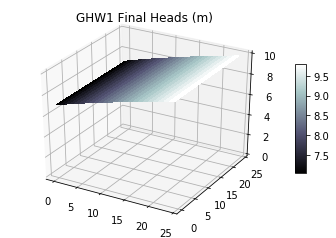

In [10]:
#Plot a 3D surface of the water table (optional: set run to True to run this section)

run = True
if run == True:
    #Create data arrays to plot
    X = np.arange(25)         #create an array of x values corresponding to model columns
    Y = np.arange(25)         #create an array of y values corresponding to model rows
    X, Y = np.meshgrid(X, Y)  #create a 2D grid for X and Y values
    Z = head[0,:,:]           #assign heads as Z values
    
    #Plot surface:
    fig3 = plt.figure()               #create figure object
    ax3 = fig3.gca(projection='3d')   #set 3D axes
    surf = ax3.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.bone, linewidth=0, antialiased=False)     #plot surface
    
    #Format plot:
    fig3.colorbar(surf, shrink=0.5, aspect=10)   #display colorbar for surface
    ax3.set_zlim(zbot,ztop, delv)                #set axis limits & spacing
    plt.title('GHW1 Final Heads (m)')            #add title
    
    #Optional extra formatting specifications (uncomment to run):
    #ax3.set_xlim(0,Lx, delr)
    #ax3.set_ylim(0,Ly, delc)
    #plt.locator_params(axis='z', nbins=nlay)    #set axis step size
    #plt.locator_params(axis='y', nbins=nrow)
    #plt.locator_params(axis='x', nbins=ncol)

    plt.show()                                 #display figure
    plt.savefig('GHW1_head_surface.png')       #save figure as a png

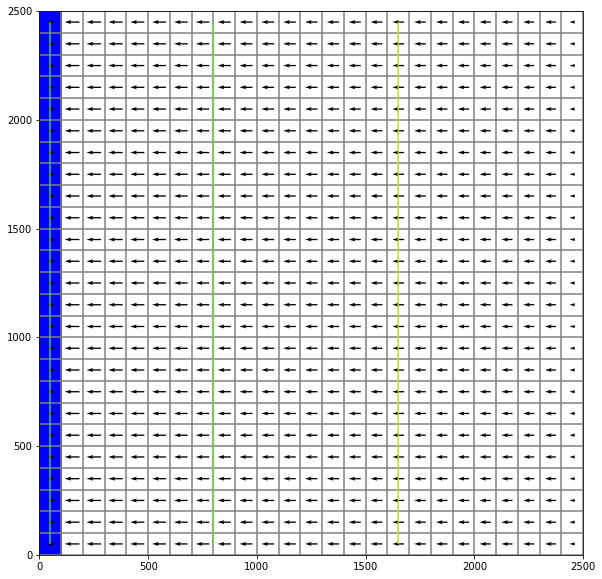

In [11]:
#Plot boundary conditions, grid, head contours, and flow vectors using ModelMap class:
#This makes a plan view contour map of the water table with flow vectors & grid cells
#(optional: set run to True to run this section)

run = True
if run == True:
    fig4 = plt.figure(figsize=(10,10))            #creates figure object
    ax4 = fig3.add_subplot(1,1,1,aspect='equal')  #creates axes object
    levels = np.linspace(0,10,11)                 #sets which contours levels to plot
    modelmap = flopy.plot.ModelMap(model=mf, layer=0)       #uses flopy plotting tool ModelMap
    qm = modelmap.plot_ibound()                             #plots constant head boundary conditions
    lc = modelmap.plot_grid()                               #plots the grid lines
    cs = modelmap.contour_array(head, levels=levels)        #makes a contour plot of heads
    quiver = modelmap.plot_discharge(frf, fff, head=head)   #plots flow vectors
    plt.savefig('GHW1_vectors.png')                         #saves figure as png

**Export & compare data**

In [12]:
#Export an array to a CSV file:
import csv                                              #import csv module (this DOESN'T import an actual csv file)
with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
    writer = csv.writer(csvfile, delimiter=',')         #sets file to write to and delimiter to use
    for i in range(len(head[0,:,0])):                   #iterate over each row in head array
        writer.writerow(head[0,i,:])                    #write each row
        

In [13]:
#Import a CSV file and convert to an array:
#This is useful for checking to see if the head distribution matches what GWV generated
#The GWV head file must first be placed in the same folder as this Python file
#Change run to "y" to run this section
run = "y"
if run == "y":
    #Import head array from GWV csv file:
    import csv                     #import csv module
    name = "GHW1_heads.csv"        #name of csv file to import
    GWVheads = np.zeros([25,25])   #create array of zeros to store heads in
    with open(name, newline='') as csvfile:   #open csv file & start reading
        reader = csv.reader(csvfile)
        i = 0                           #initialize counter
        for row in reader:              #iterate over rows
            GWVheads[i,:] = row         #store heads for each row in array
            i = i + 1                   #advance counter by one

RMSE =  0.00260910845534 m


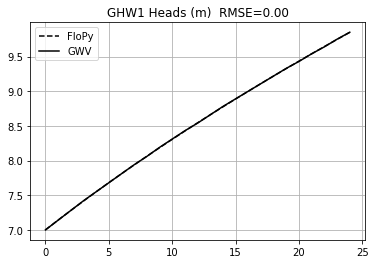

In [14]:
#Check to see how well GroundWater Vistas heads match FloPy heads:

#Calculate root mean square error between two datasets:
run = 'y'
if run == 'y':
    
    #Define RMSE function
    def rmse(predictions, targets):                                    #function_name(input1, input2)
        return np.sqrt(((predictions - targets) ** 2).mean())          #output

    #Find RMSE between FloPy and GWV results
    RMSE = rmse(head[0,:,:], GWVheads)               #call rmse function on FloPy head array & GWV head array
    print("RMSE = ",RMSE, "m")                       #print results
    
#Plot GWV head profile against FloPy head profile:
run = 'y'
if run == 'y':
    
    #Create figure & plot data:
    fig4 = plt.figure()                        #create figure and return a figure object
    ax4 = plt.subplot(1,1,1)                   #in current figure, create & return axes at position (row, col, index)
    plt.plot(np.arange(ncol), head[0,12,:], 'k--')   #plots FloPy heads at lay 0, row 12, all cols, as black dashed line
    plt.plot(np.arange(ncol), GWVheads[12,:], 'k-')  #plots GWV heads at row 12, all columns, as black line

    #Format grid & axes:
    major_ticks = np.arange(0,25,5)         #creates an array for major tick marks every 5
    minor_ticks = np.arange(0,25)           #creates an array for minor tick marks every 1

    ax1b.set_xticks(major_ticks)             #sets major ticks
    ax1b.set_xticks(minor_ticks, minor=True) #sets minor ticks

    ax4.grid(which='both')                  #turns grid on for both major and minor ticks
    ax4.legend(['FloPy','GWV'])
    plt.title('GHW1 Heads (m)  RMSE=' + '%.2f'%RMSE)    #adds a title with the RMSE to 2 decimal places 

    #Save figure:
    plt.savefig('GHW1_GWV_v_FP.png')    #optional: saves figure as a .png file